<a href="https://colab.research.google.com/github/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/pytorch/WGAN_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WGAN

元論文 : Wasserstein GAN https://arxiv.org/abs/1701.07875 (2017)

WGANはGANのLossを変えることで、数学的に画像生成の学習を良くしよう!っていうもの。

通常のGANはKLDivergenceを使って、Generatorによる確率分布を、生成したい画像の生起分布に近づけていく。だが、KLDでは連続性が保証されないので、代わりにWasserstain距離を用いて、近似していこうというのがWGAN。

Wasserstain距離によるLossを実現するために、WGANのDiscriminatorでは最後にSigmoid関数を適用しない。つまり、LossもSigmoid Cross Entropyでなく、Discriminatorの出力の値をそのまま使う。

WGANのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : RMSProp(LearningRate:0.0005)

#### Discriminatorの学習（以下操作をcriticの数値だけ繰り返す）
1. Real画像と、一様分布からzをサンプリングする
2. Loss $L_D = \frac{1}{|Minibatch|} \{ \sum_{i} D(x^{(i)}) -  \sum_i D (G(z^{(i)})) \}$ を計算し、SGD
3. Discriminatorのパラメータを全て、 [- clip, clip]　にクリッピングする

#### Generatorの学習
1. 一様分布からzをサンプリングする
2. Loss $L_G = \frac{1}{|Minibatch|}  \sum_i D (G(z^{(i)})) $ を計算し、SGD

(WGANは収束がすごく遅い、、学習回数がめちゃくちゃ必要なので、注意！！！！)

In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install numpy matplotlib opencv-python torch torchvision torchsummary pandas easydict

## Import and Config

In [0]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
from pprint import pprint

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/pytorch/')
from _main_base_generative import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 64
cfg.OUTPUT_WIDTH = 64
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = True
cfg.DEVICE_TYPE = 'cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu'
cfg.DEVICE = torch.device(cfg.DEVICE_TYPE)


# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0002, 'betas' : (0.5, 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/train/images/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = True # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = 1 # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CLIPS_VALUE = 0.01
cfg.TRAIN.WGAN_CRITIC_N = 5

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = '/content/drive/My Drive/Colab Notebooks/Dataset/test/images/'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [0]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.ConvTranspose2d(cfg.INPUT_Z_DIM, cfg.G_DIM * 4, kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], stride=1, bias=False),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 4),
            'G_layer_1_ReLU' : torch.nn.ReLU(),
            'G_layer_2' : torch.nn.ConvTranspose2d(cfg.G_DIM * 4, cfg.G_DIM * 2, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_2_bn' : torch.nn.BatchNorm2d(cfg.G_DIM * 2),
            'G_layer_2_ReLU' : torch.nn.ReLU(),
            'G_layer_3' : torch.nn.ConvTranspose2d(cfg.G_DIM * 2, cfg.G_DIM, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_3_ReLU' : torch.nn.ReLU(),
            'G_layer_out' : torch.nn.ConvTranspose2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=4, stride=2, padding=1, bias=False),
            'G_layer_out_tanh' : torch.nn.Tanh()
        }))

    def forward(self, x):
        return self.module(x)

class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1' : torch.nn.Conv2d(cfg.OUTPUT_CHANNEL, cfg.D_DIM, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_1_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_2' : torch.nn.Conv2d(cfg.D_DIM, cfg.D_DIM * 2, kernel_size=4, padding=1, stride=2, bias=False),
            'D_layer_2_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 2),
            'D_layer_2_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_3' : torch.nn.Conv2d(cfg.D_DIM * 2, cfg.D_DIM * 4, kernel_size=4, padding=1, stride=2, bias=False),
            'G_layer_3_bn' : torch.nn.BatchNorm2d(cfg.D_DIM * 4),
            'D_layer_3_leakyReLU' : torch.nn.LeakyReLU(0.2, inplace=True),
            'D_layer_out' : torch.nn.Conv2d(cfg.D_DIM * 4, 1, kernel_size=[cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_WIDTH // 8], padding=0, stride=1, bias=False),
        }))

    def forward(self, x):
        return self.module(x)


## Utility

In [0]:
def result_show(G, z, path=None, save=False, show=False,  figsize=(12, 4), cmap=None):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    plt.figure(figsize=figsize)
    
    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G, cmap=cmap)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

## Train

100%|██████████| 16/16 [00:00<00:00, 3945.49it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-2            [-1, 256, 8, 8]             512
              ReLU-3            [-1, 256, 8, 8]               0
   ConvTranspose2d-4          [-1, 128, 16, 16]         524,288
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
   ConvTranspose2d-7           [-1, 64, 32, 32]         131,072
       BatchNorm2d-8           [-1, 64, 32, 32]             128
              ReLU-9           [-1, 64, 32, 32]               0
  ConvTranspose2d-10            [-1, 3, 64, 64]           3,072
             Tanh-11            [-1, 3, 64, 64]               0
Total params: 2,756,480
Trainable params: 2,756,480
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

Iter:50, LossG (fake:1.0613), LossD:2.1090 (real:-1.1539, fake:0.9551), WDistance:-2.1090
Iter:100, LossG (fake:1.0980), LossD:2.2978 (real:-1.2577, fake:1.0401), WDistance:-2.2978
Iter:150, LossG (fake:0.9978), LossD:2.1684 (real:-1.2229, fake:0.9455), WDistance:-2.1684
Iter:200, LossG (fake:0.8944), LossD:2.0100 (real:-1.1512, fake:0.8588), WDistance:-2.0100
save G >> models/WGAN_G_iter200.pt, D >> models/WGAN_D_iter200.pt
Iter:250, LossG (fake:0.9870), LossD:2.1202 (real:-1.1761, fake:0.9442), WDistance:-2.1202
Iter:300, LossG (fake:0.9195), LossD:1.9072 (real:-1.0915, fake:0.8158), WDistance:-1.9072
Iter:350, LossG (fake:0.8767), LossD:1.9523 (real:-1.0808, fake:0.8715), WDistance:-1.9523
Iter:400, LossG (fake:0.8929), LossD:1.8305 (real:-1.0698, fake:0.7607), WDistance:-1.8305
save G >> models/WGAN_G_iter400.pt, D >> models/WGAN_D_iter400.pt
Iter:450, LossG (fake:0.8613), LossD:1.6665 (real:-1.0335, fake:0.6330), WDistance:-1.6665
Iter:500, LossG (fake:0.8076), LossD:1.7465 (real:

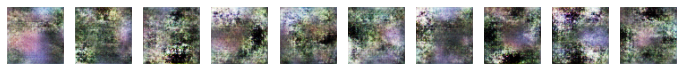

Iter:550, LossG (fake:0.8412), LossD:1.7651 (real:-0.9419, fake:0.8232), WDistance:-1.7651
Iter:600, LossG (fake:0.7332), LossD:1.8179 (real:-0.8860, fake:0.9320), WDistance:-1.8179
save G >> models/WGAN_G_iter600.pt, D >> models/WGAN_D_iter600.pt
Iter:650, LossG (fake:0.9532), LossD:1.8396 (real:-0.9803, fake:0.8593), WDistance:-1.8396
Iter:700, LossG (fake:0.9751), LossD:1.8542 (real:-0.9814, fake:0.8727), WDistance:-1.8542
Iter:750, LossG (fake:0.9880), LossD:1.9273 (real:-0.9701, fake:0.9572), WDistance:-1.9273
Iter:800, LossG (fake:0.9819), LossD:1.9418 (real:-1.0071, fake:0.9347), WDistance:-1.9418
save G >> models/WGAN_G_iter800.pt, D >> models/WGAN_D_iter800.pt
Iter:850, LossG (fake:0.7988), LossD:1.7577 (real:-0.8497, fake:0.9079), WDistance:-1.7577
Iter:900, LossG (fake:0.8833), LossD:1.9114 (real:-0.9757, fake:0.9357), WDistance:-1.9114
Iter:950, LossG (fake:0.9269), LossD:1.8290 (real:-0.8926, fake:0.9365), WDistance:-1.8290
Iter:1000, LossG (fake:0.7893), LossD:1.5787 (rea

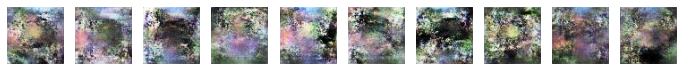

Iter:1050, LossG (fake:1.0056), LossD:1.8706 (real:-0.9970, fake:0.8736), WDistance:-1.8706
Iter:1100, LossG (fake:0.9048), LossD:1.8837 (real:-0.9741, fake:0.9096), WDistance:-1.8837
Iter:1150, LossG (fake:0.8954), LossD:1.7881 (real:-0.8705, fake:0.9176), WDistance:-1.7881
Iter:1200, LossG (fake:0.8654), LossD:1.7920 (real:-0.9923, fake:0.7997), WDistance:-1.7920
save G >> models/WGAN_G_iter1200.pt, D >> models/WGAN_D_iter1200.pt
Iter:1250, LossG (fake:0.9565), LossD:1.8650 (real:-0.9497, fake:0.9152), WDistance:-1.8650
Iter:1300, LossG (fake:0.8827), LossD:1.8038 (real:-0.9288, fake:0.8750), WDistance:-1.8038
Iter:1350, LossG (fake:0.9536), LossD:1.7567 (real:-0.9762, fake:0.7806), WDistance:-1.7567
Iter:1400, LossG (fake:0.9665), LossD:1.8821 (real:-0.9991, fake:0.8830), WDistance:-1.8821
save G >> models/WGAN_G_iter1400.pt, D >> models/WGAN_D_iter1400.pt
Iter:1450, LossG (fake:0.9816), LossD:1.8572 (real:-0.9946, fake:0.8626), WDistance:-1.8572
Iter:1500, LossG (fake:0.8315), Loss

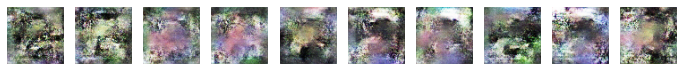

Iter:1550, LossG (fake:0.8732), LossD:1.8118 (real:-0.9508, fake:0.8610), WDistance:-1.8118
Iter:1600, LossG (fake:0.7849), LossD:1.8032 (real:-0.9324, fake:0.8708), WDistance:-1.8032
save G >> models/WGAN_G_iter1600.pt, D >> models/WGAN_D_iter1600.pt
Iter:1650, LossG (fake:0.8696), LossD:1.8506 (real:-0.9346, fake:0.9160), WDistance:-1.8506
Iter:1700, LossG (fake:0.9147), LossD:1.8687 (real:-0.9550, fake:0.9138), WDistance:-1.8687
Iter:1750, LossG (fake:0.9398), LossD:1.9040 (real:-0.9770, fake:0.9270), WDistance:-1.9040
Iter:1800, LossG (fake:0.8714), LossD:1.8599 (real:-0.9400, fake:0.9199), WDistance:-1.8599
save G >> models/WGAN_G_iter1800.pt, D >> models/WGAN_D_iter1800.pt
Iter:1850, LossG (fake:0.8728), LossD:1.8774 (real:-1.0092, fake:0.8681), WDistance:-1.8774
Iter:1900, LossG (fake:0.8416), LossD:1.8679 (real:-0.9566, fake:0.9113), WDistance:-1.8679
Iter:1950, LossG (fake:0.9128), LossD:1.8266 (real:-0.9615, fake:0.8651), WDistance:-1.8266
Iter:2000, LossG (fake:0.9632), Loss

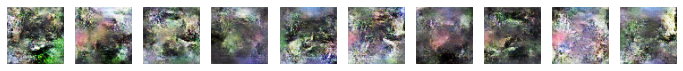

Iter:2050, LossG (fake:0.9477), LossD:1.8664 (real:-0.9619, fake:0.9045), WDistance:-1.8664
Iter:2100, LossG (fake:0.9193), LossD:1.9074 (real:-0.9957, fake:0.9117), WDistance:-1.9074
Iter:2150, LossG (fake:0.9581), LossD:1.8967 (real:-1.0326, fake:0.8641), WDistance:-1.8967
Iter:2200, LossG (fake:0.9595), LossD:1.7872 (real:-0.9957, fake:0.7915), WDistance:-1.7872
save G >> models/WGAN_G_iter2200.pt, D >> models/WGAN_D_iter2200.pt
Iter:2250, LossG (fake:0.9510), LossD:1.8525 (real:-1.0199, fake:0.8326), WDistance:-1.8525
Iter:2300, LossG (fake:0.8975), LossD:1.8930 (real:-1.0016, fake:0.8913), WDistance:-1.8930
Iter:2350, LossG (fake:0.9532), LossD:1.8371 (real:-0.9307, fake:0.9064), WDistance:-1.8371
Iter:2400, LossG (fake:0.8324), LossD:1.8157 (real:-0.9763, fake:0.8395), WDistance:-1.8157
save G >> models/WGAN_G_iter2400.pt, D >> models/WGAN_D_iter2400.pt
Iter:2450, LossG (fake:0.8699), LossD:1.7512 (real:-0.8958, fake:0.8554), WDistance:-1.7512
Iter:2500, LossG (fake:0.9288), Loss

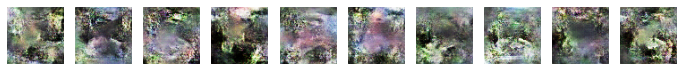

Iter:2550, LossG (fake:0.9492), LossD:1.8618 (real:-1.0178, fake:0.8440), WDistance:-1.8618
Iter:2600, LossG (fake:0.9037), LossD:1.7658 (real:-0.8870, fake:0.8788), WDistance:-1.7658
save G >> models/WGAN_G_iter2600.pt, D >> models/WGAN_D_iter2600.pt
Iter:2650, LossG (fake:0.9208), LossD:1.7771 (real:-0.9070, fake:0.8701), WDistance:-1.7771
Iter:2700, LossG (fake:0.9653), LossD:1.8023 (real:-1.0097, fake:0.7926), WDistance:-1.8023
Iter:2750, LossG (fake:0.9082), LossD:1.8685 (real:-0.9813, fake:0.8872), WDistance:-1.8685
Iter:2800, LossG (fake:0.9709), LossD:1.9027 (real:-0.9995, fake:0.9032), WDistance:-1.9027
save G >> models/WGAN_G_iter2800.pt, D >> models/WGAN_D_iter2800.pt
Iter:2850, LossG (fake:0.9887), LossD:1.8237 (real:-1.0020, fake:0.8217), WDistance:-1.8237
Iter:2900, LossG (fake:0.8432), LossD:1.9074 (real:-0.9900, fake:0.9174), WDistance:-1.9074
Iter:2950, LossG (fake:0.8740), LossD:1.7945 (real:-0.9602, fake:0.8343), WDistance:-1.7945
Iter:3000, LossG (fake:0.9016), Loss

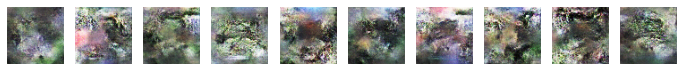

Iter:3050, LossG (fake:0.9286), LossD:1.8741 (real:-1.0102, fake:0.8639), WDistance:-1.8741
Iter:3100, LossG (fake:0.9181), LossD:1.8671 (real:-0.9786, fake:0.8885), WDistance:-1.8671
Iter:3150, LossG (fake:0.9177), LossD:1.8820 (real:-0.9724, fake:0.9096), WDistance:-1.8820
Iter:3200, LossG (fake:0.9501), LossD:1.8682 (real:-0.9691, fake:0.8991), WDistance:-1.8682
save G >> models/WGAN_G_iter3200.pt, D >> models/WGAN_D_iter3200.pt
Iter:3250, LossG (fake:0.9353), LossD:1.9028 (real:-1.0086, fake:0.8942), WDistance:-1.9028
Iter:3300, LossG (fake:0.9394), LossD:1.8691 (real:-1.0253, fake:0.8438), WDistance:-1.8691
Iter:3350, LossG (fake:0.8223), LossD:1.7112 (real:-0.8426, fake:0.8686), WDistance:-1.7112
Iter:3400, LossG (fake:0.9514), LossD:1.8988 (real:-1.0139, fake:0.8849), WDistance:-1.8988
save G >> models/WGAN_G_iter3400.pt, D >> models/WGAN_D_iter3400.pt
Iter:3450, LossG (fake:0.8744), LossD:1.8930 (real:-0.9654, fake:0.9276), WDistance:-1.8930
Iter:3500, LossG (fake:0.9480), Loss

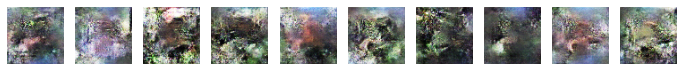

Iter:3550, LossG (fake:0.8842), LossD:1.7727 (real:-0.8802, fake:0.8925), WDistance:-1.7727
Iter:3600, LossG (fake:0.8972), LossD:1.8831 (real:-0.9755, fake:0.9077), WDistance:-1.8831
save G >> models/WGAN_G_iter3600.pt, D >> models/WGAN_D_iter3600.pt
Iter:3650, LossG (fake:0.8331), LossD:1.7801 (real:-0.9517, fake:0.8283), WDistance:-1.7801
Iter:3700, LossG (fake:0.8583), LossD:1.7998 (real:-0.9565, fake:0.8433), WDistance:-1.7998
Iter:3750, LossG (fake:0.9466), LossD:1.8327 (real:-0.9436, fake:0.8891), WDistance:-1.8327
Iter:3800, LossG (fake:0.9079), LossD:1.8795 (real:-0.9937, fake:0.8857), WDistance:-1.8795
save G >> models/WGAN_G_iter3800.pt, D >> models/WGAN_D_iter3800.pt
Iter:3850, LossG (fake:0.8501), LossD:1.8156 (real:-0.9004, fake:0.9152), WDistance:-1.8156
Iter:3900, LossG (fake:0.9321), LossD:1.8491 (real:-0.9704, fake:0.8787), WDistance:-1.8491
Iter:3950, LossG (fake:0.9288), LossD:1.8835 (real:-0.9761, fake:0.9074), WDistance:-1.8835
Iter:4000, LossG (fake:0.9855), Loss

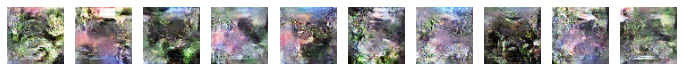

Iter:4050, LossG (fake:0.9270), LossD:1.8490 (real:-0.9710, fake:0.8780), WDistance:-1.8490
Iter:4100, LossG (fake:0.8719), LossD:1.8040 (real:-0.9507, fake:0.8534), WDistance:-1.8040
Iter:4150, LossG (fake:0.8324), LossD:1.8534 (real:-0.9668, fake:0.8866), WDistance:-1.8534
Iter:4200, LossG (fake:0.9147), LossD:1.7843 (real:-0.9584, fake:0.8260), WDistance:-1.7843
save G >> models/WGAN_G_iter4200.pt, D >> models/WGAN_D_iter4200.pt
Iter:4250, LossG (fake:0.9548), LossD:1.8859 (real:-0.9946, fake:0.8913), WDistance:-1.8859
Iter:4300, LossG (fake:0.8038), LossD:1.8580 (real:-0.9414, fake:0.9166), WDistance:-1.8580
Iter:4350, LossG (fake:0.7690), LossD:1.7747 (real:-0.9361, fake:0.8386), WDistance:-1.7747
Iter:4400, LossG (fake:0.9323), LossD:1.8581 (real:-0.9595, fake:0.8986), WDistance:-1.8581
save G >> models/WGAN_G_iter4400.pt, D >> models/WGAN_D_iter4400.pt
Iter:4450, LossG (fake:0.9350), LossD:1.8444 (real:-1.0001, fake:0.8443), WDistance:-1.8444
Iter:4500, LossG (fake:0.9293), Loss

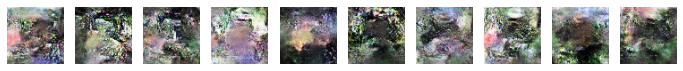

Iter:4550, LossG (fake:0.9171), LossD:1.8270 (real:-0.9682, fake:0.8589), WDistance:-1.8270
Iter:4600, LossG (fake:0.7582), LossD:1.8308 (real:-0.9264, fake:0.9043), WDistance:-1.8308
save G >> models/WGAN_G_iter4600.pt, D >> models/WGAN_D_iter4600.pt
Iter:4650, LossG (fake:0.9555), LossD:1.8291 (real:-0.9625, fake:0.8667), WDistance:-1.8291
Iter:4700, LossG (fake:0.8953), LossD:1.8205 (real:-1.0055, fake:0.8150), WDistance:-1.8205
Iter:4750, LossG (fake:0.8904), LossD:1.8229 (real:-0.9734, fake:0.8495), WDistance:-1.8229
Iter:4800, LossG (fake:0.9393), LossD:1.8900 (real:-0.9733, fake:0.9167), WDistance:-1.8900
save G >> models/WGAN_G_iter4800.pt, D >> models/WGAN_D_iter4800.pt
Iter:4850, LossG (fake:0.9464), LossD:1.8357 (real:-1.0016, fake:0.8341), WDistance:-1.8357
Iter:4900, LossG (fake:0.9550), LossD:1.8567 (real:-0.9647, fake:0.8920), WDistance:-1.8567
Iter:4950, LossG (fake:0.9045), LossD:1.8084 (real:-0.9535, fake:0.8549), WDistance:-1.8084
Iter:5000, LossG (fake:0.9771), Loss

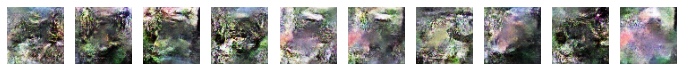

Iter:5050, LossG (fake:0.8932), LossD:1.8730 (real:-0.9757, fake:0.8973), WDistance:-1.8730
Iter:5100, LossG (fake:0.9528), LossD:1.7829 (real:-0.9742, fake:0.8086), WDistance:-1.7829
Iter:5150, LossG (fake:0.8752), LossD:1.8540 (real:-0.9534, fake:0.9005), WDistance:-1.8540
Iter:5200, LossG (fake:0.9717), LossD:1.8540 (real:-1.0024, fake:0.8515), WDistance:-1.8540
save G >> models/WGAN_G_iter5200.pt, D >> models/WGAN_D_iter5200.pt
Iter:5250, LossG (fake:0.8679), LossD:1.8236 (real:-0.9358, fake:0.8878), WDistance:-1.8236
Iter:5300, LossG (fake:0.9834), LossD:1.8855 (real:-0.9816, fake:0.9039), WDistance:-1.8855
Iter:5350, LossG (fake:0.9233), LossD:1.7908 (real:-0.9404, fake:0.8504), WDistance:-1.7908
Iter:5400, LossG (fake:0.8431), LossD:1.8820 (real:-0.9722, fake:0.9098), WDistance:-1.8820
save G >> models/WGAN_G_iter5400.pt, D >> models/WGAN_D_iter5400.pt
Iter:5450, LossG (fake:0.9328), LossD:1.7918 (real:-0.9794, fake:0.8124), WDistance:-1.7918
Iter:5500, LossG (fake:0.9344), Loss

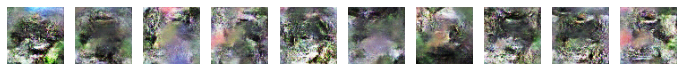

Iter:5550, LossG (fake:0.9514), LossD:1.8409 (real:-0.9806, fake:0.8603), WDistance:-1.8409
Iter:5600, LossG (fake:0.9633), LossD:1.8785 (real:-0.9704, fake:0.9081), WDistance:-1.8785
save G >> models/WGAN_G_iter5600.pt, D >> models/WGAN_D_iter5600.pt
Iter:5650, LossG (fake:0.9286), LossD:1.7569 (real:-0.9405, fake:0.8164), WDistance:-1.7569
Iter:5700, LossG (fake:0.9489), LossD:1.8345 (real:-1.0009, fake:0.8336), WDistance:-1.8345
Iter:5750, LossG (fake:0.9376), LossD:1.8561 (real:-0.9936, fake:0.8625), WDistance:-1.8561
Iter:5800, LossG (fake:0.8307), LossD:1.7620 (real:-0.8790, fake:0.8830), WDistance:-1.7620
save G >> models/WGAN_G_iter5800.pt, D >> models/WGAN_D_iter5800.pt
Iter:5850, LossG (fake:0.9289), LossD:1.8522 (real:-0.9882, fake:0.8640), WDistance:-1.8522
Iter:5900, LossG (fake:0.8900), LossD:1.8518 (real:-0.9321, fake:0.9197), WDistance:-1.8518
Iter:5950, LossG (fake:0.9163), LossD:1.7679 (real:-0.9417, fake:0.8262), WDistance:-1.7679
Iter:6000, LossG (fake:0.8491), Loss

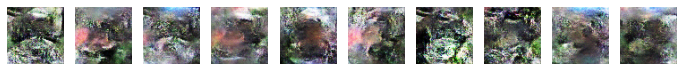

Iter:6050, LossG (fake:0.8781), LossD:1.8471 (real:-0.9653, fake:0.8818), WDistance:-1.8471
Iter:6100, LossG (fake:0.8936), LossD:1.8417 (real:-0.9484, fake:0.8933), WDistance:-1.8417
Iter:6150, LossG (fake:0.9490), LossD:1.8378 (real:-0.9650, fake:0.8728), WDistance:-1.8378
Iter:6200, LossG (fake:0.8456), LossD:1.8308 (real:-0.9513, fake:0.8795), WDistance:-1.8308
save G >> models/WGAN_G_iter6200.pt, D >> models/WGAN_D_iter6200.pt
Iter:6250, LossG (fake:0.9558), LossD:1.8095 (real:-0.9353, fake:0.8741), WDistance:-1.8095
Iter:6300, LossG (fake:0.9684), LossD:1.8058 (real:-0.9381, fake:0.8676), WDistance:-1.8058
Iter:6350, LossG (fake:0.9367), LossD:1.7622 (real:-0.9786, fake:0.7836), WDistance:-1.7622
Iter:6400, LossG (fake:0.9083), LossD:1.8639 (real:-0.9713, fake:0.8926), WDistance:-1.8639
save G >> models/WGAN_G_iter6400.pt, D >> models/WGAN_D_iter6400.pt
Iter:6450, LossG (fake:0.8785), LossD:1.7558 (real:-0.9953, fake:0.7605), WDistance:-1.7558
Iter:6500, LossG (fake:0.9241), Loss

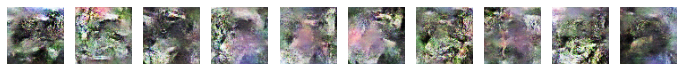

Iter:6550, LossG (fake:0.9558), LossD:1.8337 (real:-0.9544, fake:0.8792), WDistance:-1.8337
Iter:6600, LossG (fake:0.9220), LossD:1.8599 (real:-1.0004, fake:0.8595), WDistance:-1.8599
save G >> models/WGAN_G_iter6600.pt, D >> models/WGAN_D_iter6600.pt
Iter:6650, LossG (fake:0.9205), LossD:1.8615 (real:-0.9705, fake:0.8909), WDistance:-1.8615
Iter:6700, LossG (fake:0.8992), LossD:1.8609 (real:-0.9439, fake:0.9170), WDistance:-1.8609
Iter:6750, LossG (fake:0.8533), LossD:1.8358 (real:-0.9392, fake:0.8966), WDistance:-1.8358
Iter:6800, LossG (fake:0.9032), LossD:1.8584 (real:-1.0039, fake:0.8544), WDistance:-1.8584
save G >> models/WGAN_G_iter6800.pt, D >> models/WGAN_D_iter6800.pt
Iter:6850, LossG (fake:0.9405), LossD:1.7591 (real:-0.9443, fake:0.8147), WDistance:-1.7591
Iter:6900, LossG (fake:0.8934), LossD:1.8198 (real:-0.9279, fake:0.8920), WDistance:-1.8198
Iter:6950, LossG (fake:0.9399), LossD:1.8591 (real:-1.0084, fake:0.8507), WDistance:-1.8591
Iter:7000, LossG (fake:0.9139), Loss

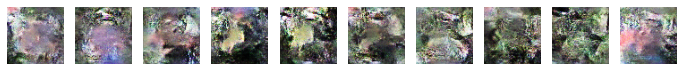

Iter:7050, LossG (fake:0.8787), LossD:1.8456 (real:-0.9497, fake:0.8959), WDistance:-1.8456
Iter:7100, LossG (fake:0.8957), LossD:1.8637 (real:-0.9809, fake:0.8829), WDistance:-1.8637
Iter:7150, LossG (fake:0.9072), LossD:1.7328 (real:-0.9250, fake:0.8078), WDistance:-1.7328
Iter:7200, LossG (fake:0.8804), LossD:1.8356 (real:-0.9603, fake:0.8753), WDistance:-1.8356
save G >> models/WGAN_G_iter7200.pt, D >> models/WGAN_D_iter7200.pt
Iter:7250, LossG (fake:0.8690), LossD:1.8254 (real:-0.9771, fake:0.8484), WDistance:-1.8254
Iter:7300, LossG (fake:0.9339), LossD:1.7937 (real:-0.9813, fake:0.8123), WDistance:-1.7937
Iter:7350, LossG (fake:0.8937), LossD:1.8592 (real:-0.9414, fake:0.9178), WDistance:-1.8592
Iter:7400, LossG (fake:0.9972), LossD:1.8677 (real:-1.0078, fake:0.8599), WDistance:-1.8677
save G >> models/WGAN_G_iter7400.pt, D >> models/WGAN_D_iter7400.pt
Iter:7450, LossG (fake:0.9258), LossD:1.8642 (real:-0.9768, fake:0.8874), WDistance:-1.8642
Iter:7500, LossG (fake:0.8652), Loss

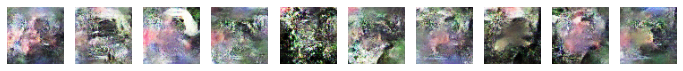

Iter:7550, LossG (fake:0.8169), LossD:1.7467 (real:-0.8623, fake:0.8844), WDistance:-1.7467
Iter:7600, LossG (fake:0.9275), LossD:1.8507 (real:-0.9851, fake:0.8656), WDistance:-1.8507
save G >> models/WGAN_G_iter7600.pt, D >> models/WGAN_D_iter7600.pt
Iter:7650, LossG (fake:0.9126), LossD:1.7799 (real:-0.9504, fake:0.8294), WDistance:-1.7799
Iter:7700, LossG (fake:0.8947), LossD:1.7790 (real:-0.9103, fake:0.8686), WDistance:-1.7790
Iter:7750, LossG (fake:0.9452), LossD:1.8529 (real:-0.9541, fake:0.8989), WDistance:-1.8529
Iter:7800, LossG (fake:0.9453), LossD:1.8144 (real:-0.9800, fake:0.8344), WDistance:-1.8144
save G >> models/WGAN_G_iter7800.pt, D >> models/WGAN_D_iter7800.pt
Iter:7850, LossG (fake:0.9426), LossD:1.8515 (real:-0.9961, fake:0.8553), WDistance:-1.8515
Iter:7900, LossG (fake:0.8377), LossD:1.8363 (real:-0.9471, fake:0.8892), WDistance:-1.8363
Iter:7950, LossG (fake:0.8680), LossD:1.8442 (real:-0.9743, fake:0.8699), WDistance:-1.8442
Iter:8000, LossG (fake:0.8692), Loss

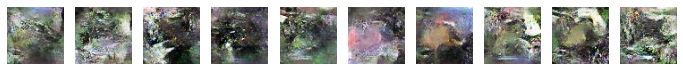

Iter:8050, LossG (fake:0.7768), LossD:1.7462 (real:-0.8727, fake:0.8736), WDistance:-1.7462
Iter:8100, LossG (fake:0.9640), LossD:1.8177 (real:-0.9683, fake:0.8494), WDistance:-1.8177
Iter:8150, LossG (fake:0.9163), LossD:1.8434 (real:-0.9803, fake:0.8632), WDistance:-1.8434
Iter:8200, LossG (fake:0.9154), LossD:1.8596 (real:-0.9772, fake:0.8824), WDistance:-1.8596
save G >> models/WGAN_G_iter8200.pt, D >> models/WGAN_D_iter8200.pt
Iter:8250, LossG (fake:0.9561), LossD:1.7774 (real:-0.9779, fake:0.7995), WDistance:-1.7774
Iter:8300, LossG (fake:0.9117), LossD:1.8645 (real:-0.9561, fake:0.9084), WDistance:-1.8645
Iter:8350, LossG (fake:0.7926), LossD:1.8184 (real:-0.9519, fake:0.8665), WDistance:-1.8184
Iter:8400, LossG (fake:0.8056), LossD:1.7854 (real:-0.9188, fake:0.8666), WDistance:-1.7854
save G >> models/WGAN_G_iter8400.pt, D >> models/WGAN_D_iter8400.pt
Iter:8450, LossG (fake:0.9396), LossD:1.8532 (real:-0.9734, fake:0.8798), WDistance:-1.8532
Iter:8500, LossG (fake:0.8606), Loss

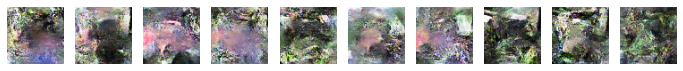

Iter:8550, LossG (fake:0.9158), LossD:1.8112 (real:-0.9010, fake:0.9103), WDistance:-1.8112
Iter:8600, LossG (fake:0.8577), LossD:1.8493 (real:-0.9503, fake:0.8990), WDistance:-1.8493
save G >> models/WGAN_G_iter8600.pt, D >> models/WGAN_D_iter8600.pt
Iter:8650, LossG (fake:0.9287), LossD:1.7561 (real:-0.9154, fake:0.8408), WDistance:-1.7561
Iter:8700, LossG (fake:0.8771), LossD:1.8550 (real:-0.9321, fake:0.9228), WDistance:-1.8550
Iter:8750, LossG (fake:0.8999), LossD:1.8034 (real:-0.9030, fake:0.9004), WDistance:-1.8034
Iter:8800, LossG (fake:0.9099), LossD:1.8342 (real:-0.9354, fake:0.8987), WDistance:-1.8342
save G >> models/WGAN_G_iter8800.pt, D >> models/WGAN_D_iter8800.pt
Iter:8850, LossG (fake:0.9202), LossD:1.7264 (real:-0.9070, fake:0.8194), WDistance:-1.7264
Iter:8900, LossG (fake:0.9414), LossD:1.8099 (real:-0.9457, fake:0.8642), WDistance:-1.8099
Iter:8950, LossG (fake:0.9251), LossD:1.8191 (real:-0.9645, fake:0.8546), WDistance:-1.8191
Iter:9000, LossG (fake:0.9655), Loss

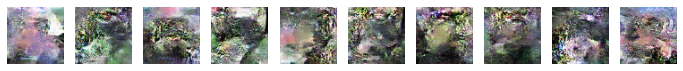

Iter:9050, LossG (fake:0.7634), LossD:1.8008 (real:-0.8970, fake:0.9038), WDistance:-1.8008
Iter:9100, LossG (fake:0.9751), LossD:1.7950 (real:-0.9941, fake:0.8009), WDistance:-1.7950
Iter:9150, LossG (fake:0.8704), LossD:1.8162 (real:-0.9210, fake:0.8951), WDistance:-1.8162
Iter:9200, LossG (fake:0.8431), LossD:1.8130 (real:-0.9122, fake:0.9007), WDistance:-1.8130
save G >> models/WGAN_G_iter9200.pt, D >> models/WGAN_D_iter9200.pt
Iter:9250, LossG (fake:0.8754), LossD:1.8420 (real:-0.9439, fake:0.8981), WDistance:-1.8420
Iter:9300, LossG (fake:0.9388), LossD:1.8265 (real:-1.0034, fake:0.8231), WDistance:-1.8265
Iter:9350, LossG (fake:0.9342), LossD:1.8524 (real:-0.9963, fake:0.8561), WDistance:-1.8524
Iter:9400, LossG (fake:0.9246), LossD:1.8722 (real:-0.9821, fake:0.8901), WDistance:-1.8722
save G >> models/WGAN_G_iter9400.pt, D >> models/WGAN_D_iter9400.pt
Iter:9450, LossG (fake:0.9416), LossD:1.8309 (real:-0.9452, fake:0.8857), WDistance:-1.8309
Iter:9500, LossG (fake:0.8521), Loss

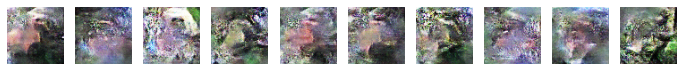

Iter:9550, LossG (fake:0.9425), LossD:1.8738 (real:-0.9901, fake:0.8837), WDistance:-1.8738
Iter:9600, LossG (fake:0.8322), LossD:1.8057 (real:-0.9280, fake:0.8776), WDistance:-1.8057
save G >> models/WGAN_G_iter9600.pt, D >> models/WGAN_D_iter9600.pt
Iter:9650, LossG (fake:0.8841), LossD:1.7828 (real:-0.9653, fake:0.8175), WDistance:-1.7828
Iter:9700, LossG (fake:0.9256), LossD:1.8485 (real:-0.9675, fake:0.8809), WDistance:-1.8485
Iter:9750, LossG (fake:0.8892), LossD:1.8389 (real:-0.9744, fake:0.8645), WDistance:-1.8389
Iter:9800, LossG (fake:0.9192), LossD:1.8077 (real:-0.9619, fake:0.8458), WDistance:-1.8077
save G >> models/WGAN_G_iter9800.pt, D >> models/WGAN_D_iter9800.pt
Iter:9850, LossG (fake:0.8628), LossD:1.7262 (real:-0.9151, fake:0.8111), WDistance:-1.7262
Iter:9900, LossG (fake:0.9372), LossD:1.8073 (real:-0.9560, fake:0.8513), WDistance:-1.8073
Iter:9950, LossG (fake:0.9127), LossD:1.8304 (real:-0.9899, fake:0.8405), WDistance:-1.8304
Iter:10000, LossG (fake:0.9126), Los

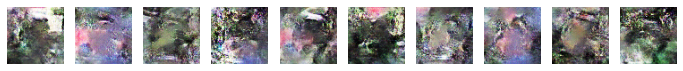

final paramters were saved to G >> models/WGAN_G_final.pt, D >> models/WGAN_D_final.pt
loss was saved to >> result/WGAN_loss.txt


In [8]:
# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)

    summary(G, (cfg.INPUT_Z_DIM, 1, 1), device=cfg.DEVICE_TYPE)
    summary(D, (cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH), device=cfg.DEVICE_TYPE)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    path_dict = data_load(cfg)
    paths = path_dict['paths']
    paths_gt = path_dict['paths_gt']

    # training
    mbi = 0
    train_N = len(paths)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []

    ones = torch.FloatTensor([1]).to(cfg.DEVICE)
    minus_ones = ones * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # parameter clipping > [-clip_value, clip_value]
            for param in D.parameters():
                param.data.clamp_(- cfg.TRAIN.WGAN_CLIPS_VALUE, cfg.TRAIN.WGAN_CLIPS_VALUE)

            # sample X
            Xs = torch.tensor(get_image(paths[mb_ind], cfg, cfg.INPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            loss_D = loss_D_fake - loss_D_real
            loss_D_real.backward(ones)
            loss_D_fake.backward(minus_ones)
            opt_D.step()
            Wasserstein_distance = loss_D_real - loss_D_fake

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(ones)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/WGAN_result_1.jpg


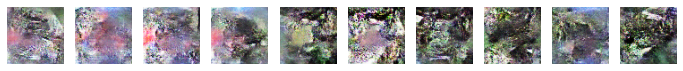

result was saved to >> result/WGAN_result_2.jpg


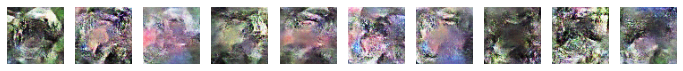

In [9]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM, 1, 1))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [0]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
